# Text Classification with RNN

This uses the fake news and real news dataset on kaggle. You can download the data here:
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [1]:
# load packages
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


/home/vector/anaconda3/envs/KerasGPU2.2.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vector/anaconda3/envs/KerasGPU2.2.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vector/anaconda3/envs/KerasGPU2.2.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vector/anaconda3/en

In [2]:
# load data
fake_news = pd.read_csv('../../Data/FakeNews/Fake.csv')
true_news = pd.read_csv('../../Data/FakeNews/True.csv')

# add the classification to the pandas dataframe
fake_news['true'] = 1
true_news['true'] = 0

# Merge data into one dataframe
news = pd.concat([true_news[['text', 'true']], fake_news[['text', 'true']]])

# split into train test validate
train, test_val = train_test_split(news, test_size=0.2)
test, val = train_test_split(test_val, test_size=0.5)

# Tokenizing

In [3]:
#%% tokenize data
max_length = 500
max_words = 1000
tokenizer = Tokenizer(num_words = max_words, oov_token = '<OOV>')

# don't include training or test data in word index
tokenizer.fit_on_texts(train['text'].values) 

# tokenize
sequences = tokenizer.texts_to_sequences(train['text'].values)
test_sequences = tokenizer.texts_to_sequences(test['text'].values)
val_sequences = tokenizer.texts_to_sequences(val['text'].values)

# pad to same length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_length)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_length)
val_sequences_matrix = sequence.pad_sequences(val_sequences, maxlen=max_length)



# Build model

In [4]:
def build_model(num_outputs = 1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(max_words, 64, input_length=max_length))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(num_outputs))
    
    return model

model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)      

In [5]:
# compile model    
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Train


In [6]:
# train
history = model.fit(sequences_matrix,
                    train['true'].values,
                    validation_data = ([val_sequences_matrix, val['true'].values]),
                    batch_size = 128,
                    epochs = 5)
    

Train on 35918 samples, validate on 4490 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
35918/35918 [==============================] - 235s 7ms/sample - loss: 1.2641 - acc: 0.4853 - val_loss: 0.7451 - val_acc: 0.5955
Epoch 2/5
35918/35918 [==============================] - 231s 6ms/sample - loss: 0.7121 - acc: 0.5535 - val_loss: 0.5664 - val_acc: 0.7354
Epoch 3/5
35918/35918 [==============================] - 230s 6ms/sample - loss: 0.4561 - acc: 0.8020 - val_loss: 0.2585 - val_acc: 0.9254
Epoch 4/5
35918/35918 [==============================] - 230s 6ms/sample - loss: 3.2531 - acc: 0.7543 - val_loss: 4.8219 - val_acc: 0.6737
Epoch 5/5
35918/35918 [==============================] - 235s 7ms/sample - loss: 5.0063 - acc: 0.6677 - val_loss: 5.3211 - val_acc: 0.6526


# Error Metrics

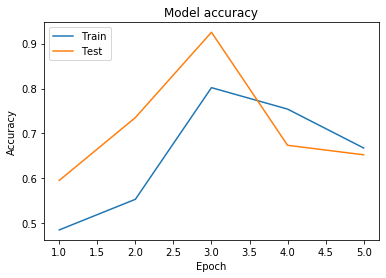

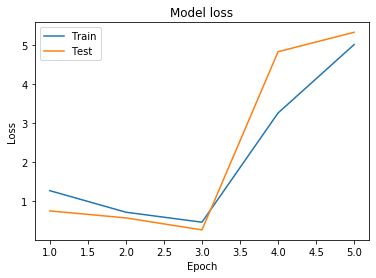

In [8]:

def plotHistory(history):
    ''' This function plots the training and validation loss and accuracy. This code has been writen in the Keras
    documentation which is very useful. 
    '''
    # Plot training & validation accuracy values
    plt.plot(np.arange(1,len(history.history['acc'])+1), history.history['acc'])
    plt.plot(np.arange(1,len(history.history['acc'])+1),history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(np.arange(1,len(history.history['acc'])+1),history.history['loss'])
    plt.plot(np.arange(1,len(history.history['acc'])+1),history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# show the training history in a plot.
plotHistory(history)


In [10]:
# we will input x_test data in to model, and get the predicted labels
predictions = model.predict(test_sequences_matrix)


In [ ]:
# print classification report
print(classification_report(test['true'].values, predictions>0.5))


In [ ]:
# print text, it's label, and model prediction
prediction_index = 5
print(test['text'].values[prediction_index])
print(test['true'].values[prediction_index])
print(predictions[prediction_index])
    